# FTP

In [1]:
_FTP_ = 225
_PATH_ = '/home/caster/training_data'

# Load dependencies

In [2]:
%run -i training_functions.py

In [3]:
t_data = read_intervals(_PATH_, _FTP_)

t_data[:10].drop(['watts_std', 'watts_25', 'watts_50', 'watts_75', 'watts_max', 'temp', 'hr_max'], axis=1)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in double_scalars


,filename,epoch_day,time,cad,hr,hr_min,hr_drift,km,kph,kilojoules,watts,np,alt,vi,tss,if,training_type
0,2017_02_18_11_13_04.utf8.json,17215,118,62.952481,151.204584,104,-0.233592,51.11070,25.871660,1064.2005,149.173045,227.744560,443.6,1.526714,152.671389,1.012198,Endurance
0,2017_02_22_17_33_49.utf8.json,17219,67,NaN,131.801924,90,NaN,24.28590,21.456039,NaN,NaN,NaN,390.6,NaN,NaN,NaN,NA
0,2017_03_07_17_47_18.utf8.json,17232,10,62.576433,137.426752,114,0.339606,4.69625,26.520306,93.3940,148.716561,216.195434,67.2,1.453741,0.000000,0.960869,Endurance
0,2017_03_07_17_47_18.utf8.json,17232,23,86.882497,171.672943,147,0.129740,18.93060,35.632825,310.9230,216.822176,234.398718,86,1.081064,0.000000,1.041772,FTP
0,2017_03_07_17_47_18.utf8.json,17232,46,71.348523,155.900576,126,-0.014478,37.26620,23.778161,400.1225,144.136347,235.856360,188.2,1.636342,0.000000,1.048250,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,4,61.197761,138.582090,118,0.002620,0.91421,12.047118,42.8330,159.824627,221.239447,39.6,1.384264,0.000000,0.983286,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,26,61.663425,145.644605,115,0.082763,23.27900,30.088589,174.7355,109.620765,186.888240,72.6,1.704862,0.000000,0.830614,Active recovery
0,2017_03_10_17_46_57.utf8.json,17235,20,80.738372,174.304817,138,0.146455,9.96009,26.927528,269.7650,224.057309,236.577337,158.6,1.055879,0.000000,1.051455,FTP
0,2017_03_11_17_34_54.utf8.json,17236,87,68.018194,135.779672,102,-0.012015,34.94850,23.891792,749.9425,142.873404,181.344455,501.2,1.269267,126.926670,0.805975,Endurance
0,2017_03_17_18_00_29.utf8.json,17242,16,81.361111,175.579293,157,0.178841,25.67930,38.147976,232.4320,234.779798,257.933357,39.6,1.098618,0.000000,1.146370,FTP


# SVR of Intensity factor over averaged watts

Values close to 1.0 should indicate the zone where FTP is located

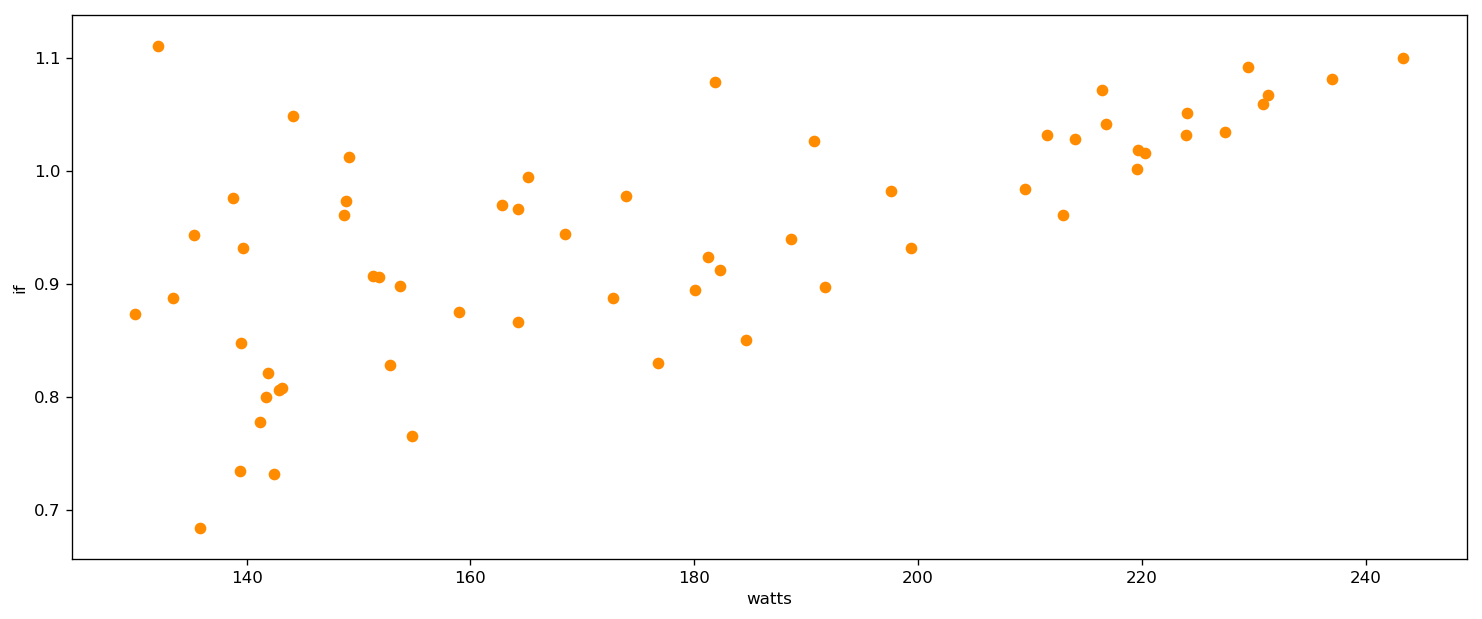

In [4]:
import matplotlib.pyplot as plt

y_values = 'if'
x_values = 'watts'

cur = t_data[(t_data['training_type']  != 'Active recovery') 
    & (t_data.time >= 10) & (t_data.watts > 130)
    & (t_data[y_values] > t_data[y_values].quantile(0.01)) 
    & (t_data[y_values] < t_data[y_values].quantile(0.95))]

cur = cur.sort_values(x_values)

plt.figure(figsize=(15, 6), dpi=120)
plt.scatter(cur[x_values], cur[y_values], color='darkorange', label='data')
plt.xlabel(x_values)
plt.ylabel(y_values)
plt.show()

/usr/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


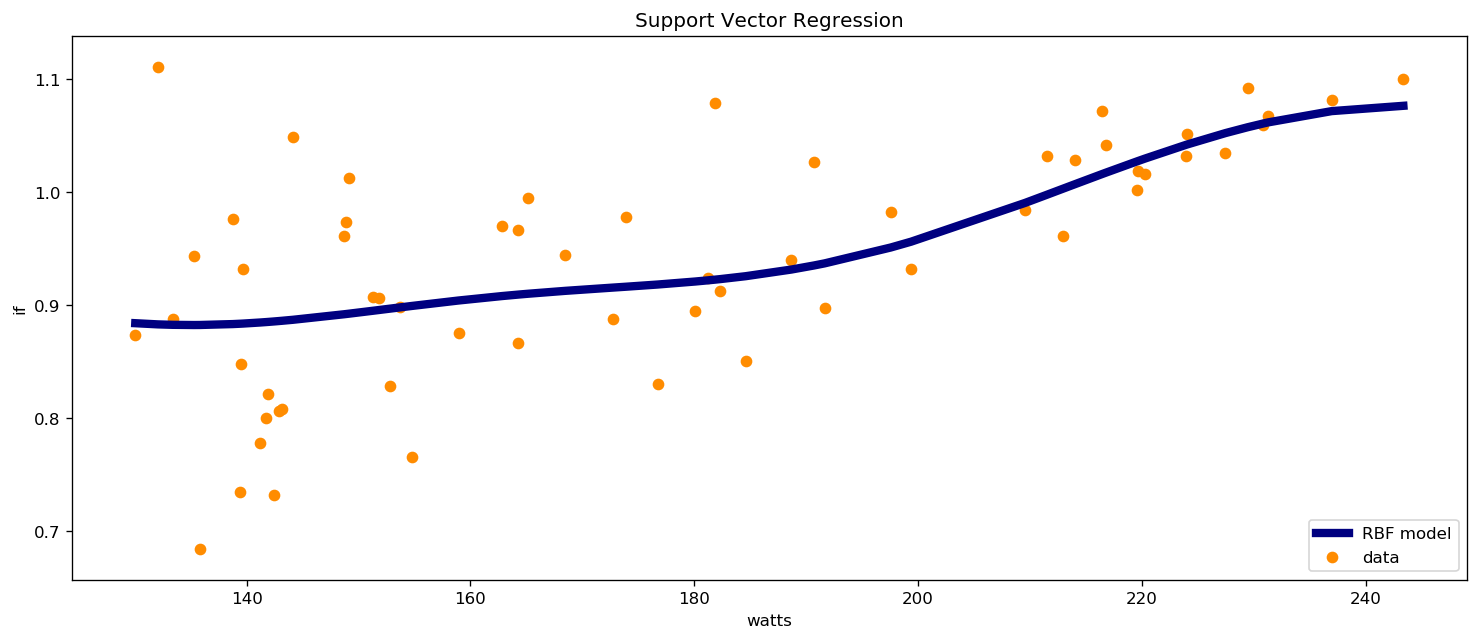

In [5]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

x1 = cur[x_values]
scx = StandardScaler()
x2 = scx.fit_transform(x1)
X = x2[:, None]

y1 = cur[y_values]
scy = StandardScaler()
y = scy.fit_transform(y1.values.reshape(-1, 1))

svr_rbf = SVR(kernel='rbf', C=0.8, gamma=0.8)
rbf_predictor = svr_rbf.fit(X, y)
y_rbf = rbf_predictor.predict(X)

# Plot
plt.figure(figsize=(15, 6), dpi=120)
plt.scatter(x1, y1, color='darkorange', label='data')
plt.plot(x1, scy.inverse_transform(y_rbf), color='navy', lw=5, label='RBF model')
plt.xlabel(x_values)
plt.ylabel(y_values)
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [6]:
power_value = 215.0
x_prediction = scx.transform(np.array([power_value]).reshape(-1,1))

print("IF for %.0f watts would be %.02f" % (power_value, scy.inverse_transform(rbf_predictor.predict(x_prediction))))

IF for 215 watts would be 1.01


# Regression tree of watts and intensity factor

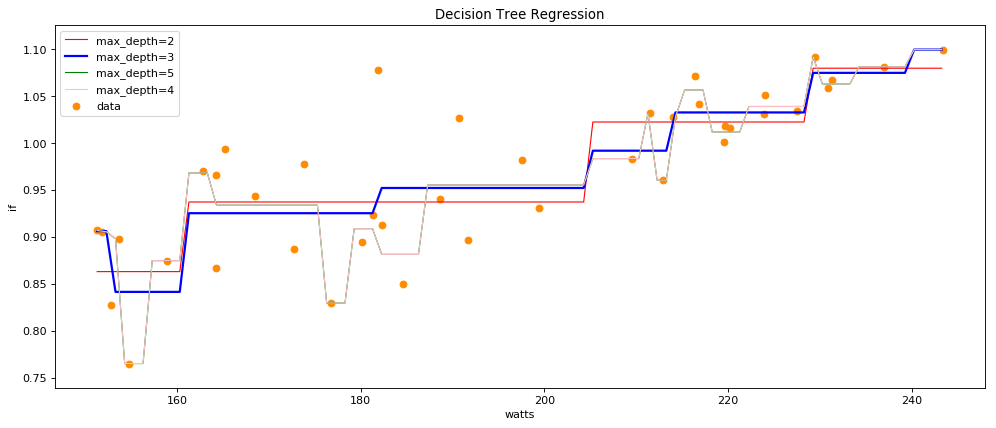

215 X Depth 2: 1.02 Y
215 X Depth 3: 1.03 Y
215 X Depth 5: 1.03 Y
215 X Depth 8: 1.05 Y


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

def regression_tree(cur, x_values, y_values, pr_hr):
    x_ = cur[x_values]
    y_ = cur[y_values]

    X = x_[:, None]
    y = y_

    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=2)
    regr_2 = DecisionTreeRegressor(max_depth=3)
    regr_3 = DecisionTreeRegressor(max_depth=5)
    regr_4 = DecisionTreeRegressor(max_depth=4)
    regr_1.fit(X, y)
    regr_2.fit(X, y)
    regr_3.fit(X, y)
    regr_4.fit(X, y)

    # Predict
    X_test = np.arange(x_.min(), x_.max(), 1)[:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)
    y_3 = regr_3.predict(X_test)
    y_4 = regr_4.predict(X_test)

    # Plot the results
    plt.figure(figsize=(15, 6), dpi=80)
    plt.scatter(X, y, c="darkorange", label="data")
    plt.plot(X_test, y_1, color="red", label="max_depth=2", linewidth=1)
    plt.plot(X_test, y_2, color="blue", label="max_depth=3", linewidth=2)
    plt.plot(X_test, y_3, color="green", label="max_depth=5", linewidth=1)
    plt.plot(X_test, y_3, color="pink", label="max_depth=4", linewidth=1)
    plt.xlabel(x_values)
    plt.ylabel(y_values)
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

    p1 = regr_1.predict(pr_hr)
    p2 = regr_2.predict(pr_hr)
    p3 = regr_3.predict(pr_hr)
    p4 = regr_4.predict(pr_hr)


    print("%d X Depth 2: %.02f Y" % (pr_hr, p1))
    print("%d X Depth 3: %.02f Y" % (pr_hr, p2))
    print("%d X Depth 5: %.02f Y" % (pr_hr, p3))
    print("%d X Depth 8: %.02f Y" % (pr_hr, p4))
    
cur = t_data[(t_data['training_type']  != 'Active recovery') 
    & (t_data.time >= 10) & (t_data.watts > 150)
    & (t_data[y_values] > t_data[y_values].quantile(0.01)) 
    & (t_data[y_values] < t_data[y_values].quantile(0.95))]

regression_tree(cur, x_values, y_values, 215)

# Linear regression of watts and if

Using 60 samples
Coefficients: 0.046344
Mean squared error: 0.00
Variance score: 0.51


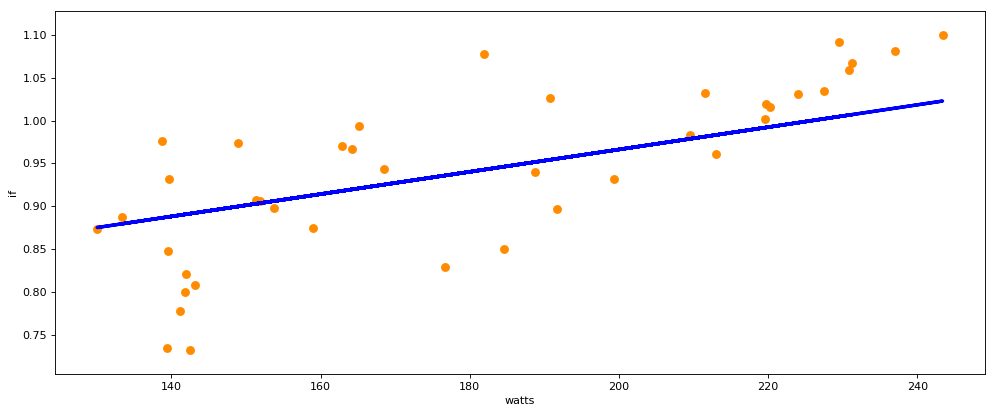

In [8]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

temp = t_data[(t_data['training_type']  != 'Active recovery') 
    & (t_data.time >= 10) & (t_data.watts > 130)
    & (t_data[y_values] > t_data[y_values].quantile(0.01)) 
    & (t_data[y_values] < t_data[y_values].quantile(0.95))]

print ('Using %d samples' % (len(temp)))

splitting_pc = 20

train_temp = temp[:20]
test_temp = temp[20:]

x_ = train_temp[x_values]
y_ = train_temp[y_values]

sc = StandardScaler()
x = sc.fit_transform(x_.values.reshape(-1, 1))
y = y_

x_test = sc.fit_transform(test_temp[x_values].values.reshape(-1,1))
y_test = test_temp[y_values]

# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(x, y)

print('Coefficients: %f' % (model.coef_[0]))
print("Mean squared error: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))
print('Variance score: %.2f' % model.score(x_test, y_test))

# Plot outputs
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(test_temp[x_values], y_test,  color='darkorange', linewidths=2)
plt.plot(test_temp[x_values], model.predict(x_test), color='blue', linewidth=3)

plt.xlabel(x_values)
plt.ylabel(y_values)

plt.show()

In [9]:
prediction = 215.0

norm_hr = sc.transform(np.array([prediction]).reshape(-1, 1))
a = model.predict(norm_hr).item(0)

print("Predicting when X = %d, Y = %.02f" % (prediction, a))

Predicting when X = 215, Y = 0.99


# Gaussian regression

In [10]:
from sklearn.preprocessing import StandardScaler

temp = t_data[(t_data['training_type']  != 'Active recovery') 
    & (t_data.time >= 10) & (t_data.watts > 130)
    & (t_data[y_values] > t_data[y_values].quantile(0.05)) 
    & (t_data[y_values] < t_data[y_values].quantile(0.92))]

x_values = 'watts'
y_values = 'np'

X = temp[x_values]
y = temp[y_values]

sc = StandardScaler()
X = sc.fit_transform(X.values.reshape(-1,1))

print ('Using %d samples' % (len(temp)))

Using 56 samples



Learned kernel: 230**2 * RBF(length_scale=21.5) + 6.58**2 * RBF(length_scale=1.31e+03) * ExpSineSquared(length_scale=0.555, periodicity=1) + 4.72**2 * RationalQuadratic(alpha=7.22e+04, length_scale=0.925) + 0.0464**2 * RBF(length_scale=2.15) + WhiteKernel(noise_level=206)
Log-marginal-likelihood: -221.586


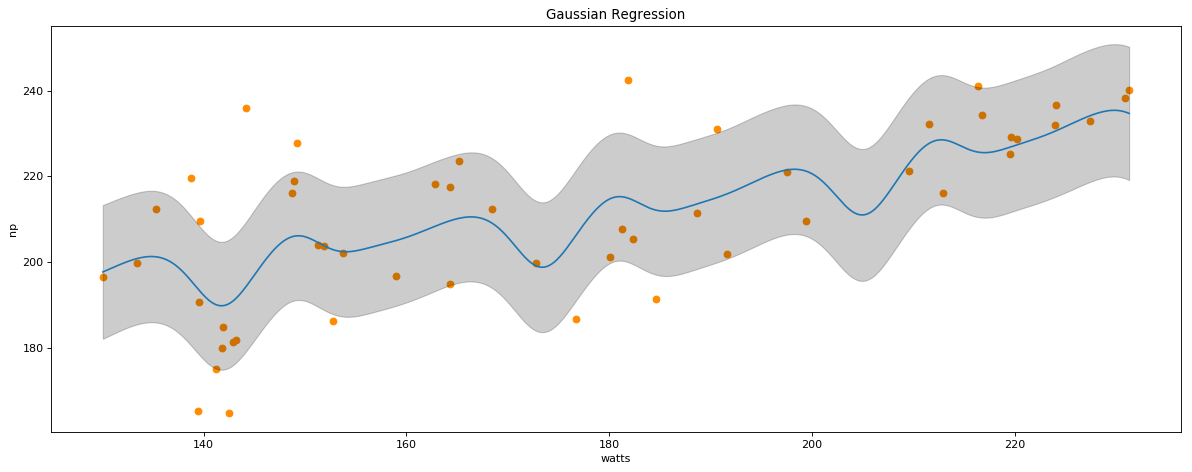

In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=False)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(sc.inverse_transform(X), y, c='darkorange')
plt.plot(sc.inverse_transform(X_), y_pred)
plt.fill_between(sc.inverse_transform(X_[:, 0]), y_pred - y_std, y_pred + y_std, alpha=0.2, color='k')
# plt.xlim(X_.min(), X_.max())
plt.xlabel(x_values)
plt.ylabel(y_values)
plt.title('Gaussian Regression')
plt.tight_layout()
plt.show()